# Getting dataset cleaned up and into Pandas

In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import json 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
os.chdir("/Users/svazire/INSIGHT/Venmo Project/Week3")
!pwd

/Users/svazire/INSIGHT/Venmo Project/Week3


## Importing Data from JSON file

In [3]:
data = []
with open('/Users/svazire/INSIGHT/Venmo Project/DATA/checked/venmo_1452213142.json') as f:
    for i, line in enumerate(f):
        if i < 3000000:
            data.append(json.loads(line))
            # insert code here
            # extract all columns
        else:
            break

l = []
for row in data:
    try:
        values = (row['updated_time'],
                  row['created_time'],
                  row['payment_id'], 
                  row['message'],
                  row['type'],
                  row['actor']['username'],
                  row['actor']['date_created'],
                  row['actor']['is_business'],
                  row['actor']['id'],
                  row['actor']['name'],
                  row['actor']['external_id'],
                  row['transactions'][0]['target']['date_created'],
                  row['transactions'][0]['target']['is_business'],
                  row['transactions'][0]['target']['username'],
                  row['transactions'][0]['target']['name'],
                  row['transactions'][0]['target']['id'],
                  row['transactions'][0]['target']['external_id'])
        l.append(values)
    except Exception as e:
        pass

data = pd.DataFrame(l, columns=['updated_time', 
                                 'created_time',
                                 'payment_id', 
                                 'message',
                                 'type_of_payment',
                                 'actor_username',
                                 'actor_date_created',
                                 'actor_is_business',
                                 'actor_id',
                                 'actor_name',
                                 'actor_external_id',
                                 'target_date_created',
                                 'target_is_business',
                                 'target_username',
                                 'target_name',
                                 'target_id',
                                 'target_external_id'])

#dropping irrelevant columns
data.drop(['created_time','target_is_business','actor_is_business',
          'actor_id','actor_name','target_name','actor_external_id',
           'target_id','target_external_id','payment_id',
           'actor_date_created','target_date_created'],axis=1, inplace=True)

#changing column order
data = data[['actor_username','target_username','updated_time',
             'message','type_of_payment']]

#shortening names
data.rename(columns = {'actor_username': 'actor', 'target_username': 'target',
                     'updated_time': 'time','type_of_payment':'type'}, inplace = True)

# Outline
#### 1) hand labeling businesses
#### 2) add column for total rows
#### 3) Creating SHORT
#### 4a) EDIT DISTANCE Variable
#### 4b) Time Variables
#### 5) Building SD variables
#### 7) DBSCAN
#### 8) Gephi

### 1) hand labeling businesses

In [42]:
#creating new biz column
data['business'] = int(0)

In [43]:
#labeling users as businesses
data.loc[data.actor == 'ibotta', 'business'] = int(1)
data.loc[data.actor == 'MoveLootInc', 'business'] = int(1)
data.loc[data.actor == 'SeatGeek', 'business'] = int(1)
data.loc[data.actor == 'GOAT', 'business'] = int(1)
data.loc[data.actor == 'USCDKA', 'business'] = int(1)
data.loc[data.actor == 'FitSpot', 'business'] = int(1)
data.loc[data.actor == 'AmericanHeartAssociation', 'business'] = int(1)

### 2) add column for total rows

In [44]:
files = data.actor.value_counts()
#merging two datasets together that have unequal rows
data['actor_copy'] = data.actor
data = data.set_index('actor_copy')
data['line_count'] = files

### 4b) Time variables

In [45]:
from datetime import datetime

In [46]:
data['month'] = pd.to_datetime(data.time).dt.month
data['year'] = pd.to_datetime(data.time).dt.year
data['day'] = pd.to_datetime(data.time).dt.day
data['hour'] = pd.to_datetime(data.time).dt.hour
data['weekday'] = pd.to_datetime(data.time).dt.weekday

In [47]:
#loop to get weekend 0:1
def f(row):
    if row['weekday'] == 5:
        val = 1
    elif row['weekday'] == 6:
        val = 1
    else:
        val = 0
    return val
data['Weekend'] = data.apply(f, axis=1)

In [48]:
#loop to get workday 0:1
def tut(row):
    if row['hour'] == 9:
        val = 1
    elif row['hour'] == 10:
        val = 1
    elif row['hour'] == 11:
        val = 1
    elif row['hour'] == 12:
        val = 1
    elif row['hour'] == 13:
        val = 1
    elif row['hour'] == 14:
        val = 1
    elif row['hour'] == 15:
        val = 1
    elif row['hour'] == 16:
        val = 1
    else:
        val = 0
    return val
data['Workday'] = data.apply(tut, axis=1)

#### 4c) Making ratio variable

In [49]:
#loop to get weekend 0:1
def f(row):
    if row['type'] == 'charge':
        val = 0
    elif row['type'] == 'payment':
        val = 1
    else:
        return
    return val
data['Type_coded'] = data.apply(f, axis=1)

#### Getting unique message Feature

## 5b) Making CRUNCH

In [50]:
dataSHORT = data.groupby(data.index).mean()
dataSHORT['actor'] = dataSHORT.index

## Making Unique Message variable

In [51]:
#Getting # of unique messages
table2=data.groupby(['actor'])['message'].nunique().reset_index()
table2['total_count']=data.groupby(['actor'])['message'].count().values
table2['messages_percentsame'] = (table2.message / table2.total_count)

In [52]:
#combining dataSHORT and table2
table2['actor_copy'] = table2.actor
table2 = table2.set_index('actor_copy')
table2.drop('actor', axis=1, inplace=True)
dataSHORT = pd.concat([dataSHORT, table2], axis=1)

In [53]:
data.query('actor == "ibotta"')

,actor,target,time,message,type,business,line_count,month,year,day,hour,weekday,Weekend,Workday,Type_coded
actor_copy,,,,,,,,,,,,,,,
ibotta,ibotta,Shirley-Hoyle,2016-01-08T00:34:24Z,Withdrew cash from Ibotta - A fun way to earn ...,payment,1,5676,1,2016,8,0,4,0,0,1
ibotta,ibotta,Pam-Goodloe,2016-01-08T00:29:16Z,Withdrew cash from Ibotta - A fun way to earn ...,payment,1,5676,1,2016,8,0,4,0,0,1
ibotta,ibotta,sandra-Bozung-1,2016-01-08T00:28:10Z,Withdrew cash from Ibotta - A fun way to earn ...,payment,1,5676,1,2016,8,0,4,0,0,1
ibotta,ibotta,nina-d,2016-01-08T00:15:58Z,Withdrew cash from Ibotta - A fun way to earn ...,payment,1,5676,1,2016,8,0,4,0,0,1
ibotta,ibotta,Kaci-Moorhouse,2016-01-08T00:13:25Z,Withdrew cash from Ibotta - A fun way to earn ...,payment,1,5676,1,2016,8,0,4,0,0,1
ibotta,ibotta,Nikki-WeissBetz,2016-01-07T23:55:52Z,Withdrew cash from Ibotta - A fun way to earn ...,payment,1,5676,1,2016,7,23,3,0,0,1
ibotta,ibotta,Maria-Garcia-Autry,2016-01-07T23:43:26Z,Withdrew cash from Ibotta - A fun way to earn ...,payment,1,5676,1,2016,7,23,3,0,0,1
ibotta,ibotta,Charles-Bruno-1,2016-01-07T23:38:06Z,Withdrew cash from Ibotta - A fun way to earn ...,payment,1,5676,1,2016,7,23,3,0,0,1
ibotta,ibotta,Rainey,2016-01-09T18:31:11Z,Withdrew cash from Ibotta - A fun way to earn ...,payment,1,5676,1,2016,9,18,5,1,0,1


In [54]:
dataSHORT.drop('line_count', axis=1, inplace=True)
#shortening names
dataSHORT.rename(columns = {'message':'unique_messages','total_count':'total_messages'}, inplace = True)

In [55]:
data.drop('business', axis=1, inplace=True)

In [56]:
dataSHORT.drop('month', axis=1, inplace=True)
dataSHORT.drop('year', axis=1, inplace=True)
dataSHORT.drop('day', axis=1, inplace=True)
dataSHORT.drop('hour', axis=1, inplace=True)
dataSHORT.drop('weekday', axis=1, inplace=True)

In [57]:
data=data.reset_index()

In [58]:
data.drop('actor_copy', axis=1, inplace=True)


In [59]:
data.drop('Weekend', axis=1, inplace=True)
data.drop('line_count', axis=1, inplace=True)
data.drop('Workday', axis=1, inplace=True)
data.drop('Type_coded', axis=1, inplace=True)

In [60]:
#resetting index
dataSHORT.reset_index(inplace=True)
dataSHORT.drop('actor_copy', axis=1, inplace=True)

In [61]:
#changing column order
dataSHORT = dataSHORT[['actor','Workday','Weekend','Type_coded','unique_messages','messages_percentsame','total_messages','business']]

In [66]:
data.sort(['day'], ascending=False)

/Users/svazire/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,actor,target,time,message,type,month,year,day,hour,weekday
1310479,Kelvin-Du,EthanTom,2016-03-31T19:29:07Z,Schoolizlyfe,payment,3,2016,31,19,3
2424299,Kelsey-Cullen,Aidah-Clinton,2014-08-31T19:04:39Z,The good stuff,payment,8,2014,31,19,6
2424301,Jena-Nguyen,Soo-Cho,2014-08-31T19:04:38Z,Anaconda,payment,8,2014,31,19,6
2424302,Bernadette-Wharton,Sarahhbelll,2014-08-31T19:04:37Z,Chuck,payment,8,2014,31,19,6
2424303,Gabe-Gelbard,Jack-Roth-1,2014-08-31T19:04:36Z,House supplies,charge,8,2014,31,19,6
2424304,Carmelle-Koren,Seamus-Powers,2014-08-31T19:04:33Z,Taxi day 2,payment,8,2014,31,19,6
2424306,Veronica-Cadavid,Vani-Patel-1,2014-08-31T22:16:47Z,Fun,payment,8,2014,31,22,6
2424307,Cole-Murphy-Hockett,Lanny-DiFranza,2014-08-31T21:12:28Z,EZOO supplies,payment,8,2014,31,21,6
2424308,Paul-Buonomo,kadams12,2014-08-31T19:04:26Z,league,payment,8,2014,31,19,6
2424309,Penny-Zhang,markding,2014-08-31T19:04:24Z,Cashes,payment,8,2014,31,19,6


In [67]:
data.head(n=15)

,actor,target,time,message,type,month,year,day,hour,weekday
0,CherylMae-Granada,Lydia-Fritzsche,2016-01-08T00:38:23Z,Lol,payment,1,2016,8,0,4
1,Kaili-Crow,Connor-Longust,2016-01-08T00:38:23Z,Chipotle share,payment,1,2016,8,0,4
2,Jtague87,Dylan-Steil,2016-01-08T00:38:23Z,Drone,charge,1,2016,8,0,4
3,Laura-Watson-12,MeredithWatson,2016-01-08T00:38:23Z,Reimbursement,payment,1,2016,8,0,4
4,natalie-davis-1,Brinna-Clark,2016-01-08T00:38:23Z,🍴 💯🐷,payment,1,2016,8,0,4
5,Anna-Howard-5,Maty-Cumberland,2016-01-08T00:38:22Z,Kale,payment,1,2016,8,0,4
6,JoeGarrett,Cooper-Ramstead,2016-01-08T00:38:22Z,Craft elixirs,payment,1,2016,8,0,4
7,Ann-Bassoni,Allison-Haas-3,2016-01-08T00:42:01Z,for subscription to dating site...,payment,1,2016,8,0,4
8,Matt-Colwill,JMasters,2016-01-08T00:38:21Z,Stars tickets,payment,1,2016,8,0,4
9,Casey-Francisco,Bridget-Francisco,2016-01-08T00:38:21Z,Ty,payment,1,2016,8,0,4


# One-class SVM

In [64]:
dataSHORT.head()

,actor,Workday,Weekend,Type_coded,unique_messages,messages_percentsame,total_messages,business
0,A-A-R0N,0.000000,1.000000,1.000000,1,1.000000,1,0.0
1,A-A-Ron-Slater,1.000000,0.000000,1.000000,1,1.000000,1,0.0
2,A-A-Ron1,0.428571,0.571429,0.428571,5,0.714286,7,0.0
3,A-A-ron-Hirschi,0.000000,0.000000,1.000000,1,0.500000,2,0.0
4,A-Afilal,0.000000,0.250000,1.000000,2,0.500000,4,0.0


In [108]:
import matplotlib.font_manager
from sklearn import svm
from patsy import dmatrices
import sklearn
from sklearn import preprocessing

In [109]:
dataPLAY = dataSHORT.head(n=10000)

In [78]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 25, 500))

In [81]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('business ~ total_messages', dataPLAY, return_type="dataframe")
#note: if you have a categorical IV wrap it in C() ; e.g., + C(occupation),
print (X.columns)

Index(['Intercept', 'total_messages'], dtype='object')


In [8]:
newblock_set = X.reset_index(drop=True)

NameError: name 'X' is not defined

In [144]:
scaler = preprocessing.StandardScaler()
X = 

In [145]:
#splitting into test and train
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.7, random_state=0)

In [146]:
print(X_train.shape)
print(X_test.shape)

(3000, 2)
(7000, 2)


In [147]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [148]:
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
y_pred = clf.predict(X)

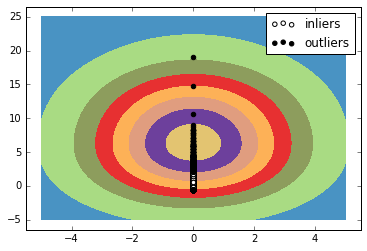

In [176]:
import pylab as pl
pl.set_cmap(pl.cm.Paired)
pl.contourf(xx, yy, Z)
pl.scatter(X[y_pred>0,0], X[y_pred>0,1], c='white', label='inliers')
pl.scatter(X[y_pred<=0,0], X[y_pred<=0,1], c='black', label='outliers')
pl.axis('tight')
pl.legend()
pl.show()

In [82]:
from sklearn.manifold import TSNE

In [130]:
dataATTILA = dataSHORT.head(n=2000)

In [132]:
dataATTILA.head()

,Workday,Weekend,Type_coded,unique_messages,messages_percentsame,total_messages
0,0.000000,1.000000,1.000000,1,1.000000,1
1,1.000000,0.000000,1.000000,1,1.000000,1
2,0.428571,0.571429,0.428571,5,0.714286,7
3,0.000000,0.000000,1.000000,1,0.500000,2
4,0.000000,0.250000,1.000000,2,0.500000,4


In [131]:
dataATTILA.drop('actor', axis=1, inplace=True)
dataATTILA.drop('business', axis=1, inplace=True)

/Users/svazire/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/svazire/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [96]:
dataATTILA = dataATTILA.as_matrix()

In [97]:
vectors = dataATTILA      

In [112]:
tsne = TSNE(n_components=10, random_state=0)
vectors2d = tsne.fit_transform(vectors)

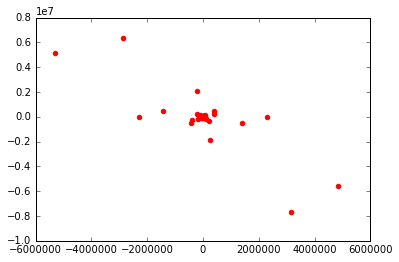

In [113]:
plt.scatter(vectors2d[:,0],vectors2d[:,1],color='r')
#plt.scatter(vectors2d[Nyn:,0],vectors2d[Nyn:,1],color='b')

In [145]:
#splitting into test and train
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.7, random_state=0)

In [146]:
print(X_train.shape)
print(X_test.shape)

(3000, 2)
(7000, 2)


In [147]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [148]:
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
y_pred = clf.predict(X)

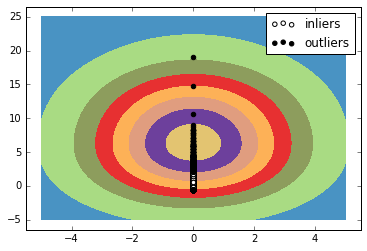

In [176]:
import pylab as pl
pl.set_cmap(pl.cm.Paired)
pl.contourf(xx, yy, Z)
pl.scatter(X[y_pred>0,0], X[y_pred>0,1], c='white', label='inliers')
pl.scatter(X[y_pred<=0,0], X[y_pred<=0,1], c='black', label='outliers')
pl.axis('tight')
pl.legend()
pl.show()

## Elliptic Envelope

In [152]:
   y_pred = clf.predict(X) 

ValueError: X.shape[1] = 6 should be equal to 1, the number of features at training time

In [ ]:
    decision = clf.decision_function(X, raw_values=True)
    decision_transformed = clf.decision_function(X, raw_values=False)

### 6) Basic Logistic Regression

#### online help
http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976
http://machinelearningmastery.com/get-your-hands-dirty-with-scikit-learn-now/
from Jamie: 

In [125]:
small = dataSHORT['actor'] != 'ibotta'
datanoibotta = dataSHORT[small]

In [126]:
#Test1: What's the mean difference between biz and non-biz?
datanoibotta.groupby('business').mean()

,line_count,Workday,Weekend,Type_coded
business,,,,
0.0,2.497582,0.16006,0.375367,0.885611
1.0,90.000000,0.09485,0.228188,1.000000


In [102]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score


##### Input multiple Features into X for regression
http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976

In [104]:
dataSHORT.head()

,actor,Workday,Weekend,Type_coded,unique_messages,messages_percentsame,total_messages,business
0,A-A-R0N,0.000000,1.000000,1.000000,1,1.000000,1,0.0
1,A-A-Ron-Slater,1.000000,0.000000,1.000000,1,1.000000,1,0.0
2,A-A-Ron1,0.428571,0.571429,0.428571,5,0.714286,7,0.0
3,A-A-ron-Hirschi,0.000000,0.000000,1.000000,1,0.500000,2,0.0
4,A-Afilal,0.000000,0.250000,1.000000,2,0.500000,4,0.0


In [110]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('business ~ total_messages + Type_coded + Weekend + Workday', dataSHORT, return_type="dataframe")
#note: if you have a categorical IV wrap it in C() ; e.g., + C(occupation),
print (X.columns)

Index(['Intercept', 'total_messages', 'Type_coded', 'Weekend', 'Workday'], dtype='object')


In [111]:
# flatten y into a 1-D array
y = np.ravel(y)

In [112]:
#splitting into test and train
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.7, random_state=0)

In [131]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_test,y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [132]:
model.score(X_test,y_test)

0.99999842247157689

In [124]:
#merging array column of X-model with original dataframe
mod1 = model.predict_proba(X_train)

In [235]:
X_train['pretty'] = mod1[:,0]

/Users/svazire/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [211]:
X_train.sort_values(['pretty'], ascending=True).head(n=40)

,Intercept,line_count,Type_coded,Weekend,Workday,pretty
actor_copy,,,,,,
ibotta,1.0,5676.0,1.000000,0.332276,0.215292,0.000000
Chelsea-Koehler,1.0,69.0,0.072464,0.275362,0.043478,0.995380
Eden-Dolev,1.0,72.0,0.111111,0.555556,0.180556,0.996328
Bryan-Godel,1.0,64.0,0.046875,0.062500,0.125000,0.996379
Caroline-Broderick,1.0,55.0,0.127273,0.181818,0.072727,0.998546
FDelgado,1.0,56.0,0.089286,0.410714,0.107143,0.998650
Raunak-Jhaveri,1.0,52.0,0.115385,0.230769,0.057692,0.998850
GOAT,1.0,73.0,1.000000,0.041096,0.027397,0.998855
Melissa-Waldman,1.0,48.0,0.104167,0.041667,0.000000,0.998924


In [329]:
#looking at specific case
print (data2.ix[1755067])

actor                   roseking
business                       0
unique_messages               44
total_messages                90
messages_percentsame    0.488889
Name: 1755067, dtype: object


### Confusion Matrix

In [125]:
from sklearn.metrics import confusion_matrix

In [126]:
confusion_matrix(y_train, model.predict(X_train))

array([[543343,      0],
       [     1,      1]])

In [250]:
#http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
#ACCURACY: (True Pos+True Neg) / total
(1+543342)/543346

0.9999944786563258

In [253]:
#misclassification rate
(3+0)/543346

5.521343674196552e-06

In [243]:
#True positive rate: 
1/1

1.0

In [ ]:
#False positive rate:
0/543345

In [252]:
#Specificity
543342/543345

0.9999944786461641

In [251]:
#PRECISION:
1/4

0.25

In [249]:
#PREVALENCE
4/543346

7.361791565595403e-06

### Plotting

In [69]:
mass = data2['actor'] != 'ibotta'
data3 = data2[mass]

In [77]:
import matplotlib.pyplot as plt

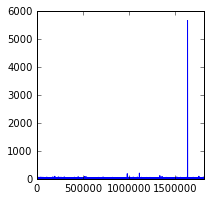

In [96]:
fig = plt.figure()
plt2 = data2.total_messages.plot()
fig.set_size_inches(3,3)
plt.savefig("test7.jpg",dpi=1500)

In [83]:
plt.savefig('./tester4.png', format='png')

## 8) Network X

In [160]:
import networkx as nx
G = nx.Graph()

density g.density("of clusters")
nx connected components --> find connected components, then run density on each cluster
mcl in micans


In [162]:
# creating subsets: dataPay & dataCharge
mass = data['type'] == 'payment'
dataPayment = data[mass]

In [168]:
data_tmp = dataPayment.head(1000)

In [169]:
G.add_edges_from(np.array(data_tmp[['actor', 'target']]), types = str(data_tmp['type']) )

In [170]:
list_nodes = G.nodes()
for node in list_nodes:
    if G.degree(node) <= 3:
        G.remove_node(node)

In [129]:
#nx.write_gml(G, './Venmo_Wed10.gml')

#### Another try

### 4a) EDIT DISTANCE Variable

In [189]:
import editdistance as ed

In [74]:
ed.eval('comments', 'target')

6

In [ ]:
dfs = pd.DataFrame([df.comments.tolist()] * df.shape[0], index=df.index, columns=df.index)
dfs = dfs.applymap(lambda x: list([x]))
print dfs

In [89]:
df = data.query('actor == "SeatGeek"')

In [93]:
from numpy import triu, ones

In [99]:
df1 = pd.DataFrame([df.message.tolist()] * df.shape[0], index=df.index, columns=df.index)
df1 = df1.applymap(lambda x: list([x]))

In [103]:
dfd = df1 + df1.T
dfd = dfd.mask(triu(ones(dfd.shape)).astype(bool))
print (dfd)

                                  15528                             15599   \
15528                                NaN                               NaN   
15599   [Payment dzmscr, Payment c9fcvg]                               NaN   
15643   [Payment dzmscr, Payment dqcdzg]  [Payment c9fcvg, Payment dqcdzg]   
15646   [Payment dzmscr, Payment hzgtc6]  [Payment c9fcvg, Payment hzgtc6]   
15672   [Payment dzmscr, Payment gygscr]  [Payment c9fcvg, Payment gygscr]   
15679   [Payment dzmscr, Payment csrwyb]  [Payment c9fcvg, Payment csrwyb]   
180615  [Payment dzmscr, Payment 2xpy4b]  [Payment c9fcvg, Payment 2xpy4b]   
180622  [Payment dzmscr, Payment 4dnccr]  [Payment c9fcvg, Payment 4dnccr]   
180631  [Payment dzmscr, Payment 2g2tc6]  [Payment c9fcvg, Payment 2g2tc6]   
180642  [Payment dzmscr, Payment 58j3xr]  [Payment c9fcvg, Payment 58j3xr]   
180661  [Payment dzmscr, Payment 8yfd6m]  [Payment c9fcvg, Payment 8yfd6m]   
180685  [Payment dzmscr, Payment 597h9g]  [Payment c9fcvg, Payme

In [105]:
L.distance

NameError: name 'L' is not defined

In [104]:
dfd.applymap(lambda x: L.distance(x[0], x[1]))

NameError: ("name 'L' is not defined", 'occurred at index 15528')

In [100]:
df1.head(n=40)

,15528,15599,15643,15646,15672,15679,180615,180622,180631,180642,...,86443,86475,86498,86525,86538,66430,66483,220424,220443,220461
15528,[Payment dzmscr],[Payment c9fcvg],[Payment dqcdzg],[Payment hzgtc6],[Payment gygscr],[Payment csrwyb],[Payment 2xpy4b],[Payment 4dnccr],[Payment 2g2tc6],[Payment 58j3xr],...,[Payment cxcjx6],[Payment kh58m2],[Payment kg9cvg],[Payment bs2ym2],[Payment gx34hr],[Payment k93dfg],[Payment h5m93r],[Payment jth44b],[Payment dxxxmm],[Payment fnz6w2]
15599,[Payment dzmscr],[Payment c9fcvg],[Payment dqcdzg],[Payment hzgtc6],[Payment gygscr],[Payment csrwyb],[Payment 2xpy4b],[Payment 4dnccr],[Payment 2g2tc6],[Payment 58j3xr],...,[Payment cxcjx6],[Payment kh58m2],[Payment kg9cvg],[Payment bs2ym2],[Payment gx34hr],[Payment k93dfg],[Payment h5m93r],[Payment jth44b],[Payment dxxxmm],[Payment fnz6w2]
15643,[Payment dzmscr],[Payment c9fcvg],[Payment dqcdzg],[Payment hzgtc6],[Payment gygscr],[Payment csrwyb],[Payment 2xpy4b],[Payment 4dnccr],[Payment 2g2tc6],[Payment 58j3xr],...,[Payment cxcjx6],[Payment kh58m2],[Payment kg9cvg],[Payment bs2ym2],[Payment gx34hr],[Payment k93dfg],[Payment h5m93r],[Payment jth44b],[Payment dxxxmm],[Payment fnz6w2]
15646,[Payment dzmscr],[Payment c9fcvg],[Payment dqcdzg],[Payment hzgtc6],[Payment gygscr],[Payment csrwyb],[Payment 2xpy4b],[Payment 4dnccr],[Payment 2g2tc6],[Payment 58j3xr],...,[Payment cxcjx6],[Payment kh58m2],[Payment kg9cvg],[Payment bs2ym2],[Payment gx34hr],[Payment k93dfg],[Payment h5m93r],[Payment jth44b],[Payment dxxxmm],[Payment fnz6w2]
15672,[Payment dzmscr],[Payment c9fcvg],[Payment dqcdzg],[Payment hzgtc6],[Payment gygscr],[Payment csrwyb],[Payment 2xpy4b],[Payment 4dnccr],[Payment 2g2tc6],[Payment 58j3xr],...,[Payment cxcjx6],[Payment kh58m2],[Payment kg9cvg],[Payment bs2ym2],[Payment gx34hr],[Payment k93dfg],[Payment h5m93r],[Payment jth44b],[Payment dxxxmm],[Payment fnz6w2]
15679,[Payment dzmscr],[Payment c9fcvg],[Payment dqcdzg],[Payment hzgtc6],[Payment gygscr],[Payment csrwyb],[Payment 2xpy4b],[Payment 4dnccr],[Payment 2g2tc6],[Payment 58j3xr],...,[Payment cxcjx6],[Payment kh58m2],[Payment kg9cvg],[Payment bs2ym2],[Payment gx34hr],[Payment k93dfg],[Payment h5m93r],[Payment jth44b],[Payment dxxxmm],[Payment fnz6w2]
180615,[Payment dzmscr],[Payment c9fcvg],[Payment dqcdzg],[Payment hzgtc6],[Payment gygscr],[Payment csrwyb],[Payment 2xpy4b],[Payment 4dnccr],[Payment 2g2tc6],[Payment 58j3xr],...,[Payment cxcjx6],[Payment kh58m2],[Payment kg9cvg],[Payment bs2ym2],[Payment gx34hr],[Payment k93dfg],[Payment h5m93r],[Payment jth44b],[Payment dxxxmm],[Payment fnz6w2]
180622,[Payment dzmscr],[Payment c9fcvg],[Payment dqcdzg],[Payment hzgtc6],[Payment gygscr],[Payment csrwyb],[Payment 2xpy4b],[Payment 4dnccr],[Payment 2g2tc6],[Payment 58j3xr],...,[Payment cxcjx6],[Payment kh58m2],[Payment kg9cvg],[Payment bs2ym2],[Payment gx34hr],[Payment k93dfg],[Payment h5m93r],[Payment jth44b],[Payment dxxxmm],[Payment fnz6w2]
180631,[Payment dzmscr],[Payment c9fcvg],[Payment dqcdzg],[Payment hzgtc6],[Payment gygscr],[Payment csrwyb],[Payment 2xpy4b],[Payment 4dnccr],[Payment 2g2tc6],[Payment 58j3xr],...,[Payment cxcjx6],[Payment kh58m2],[Payment kg9cvg],[Payment bs2ym2],[Payment gx34hr],[Payment k93dfg],[Payment h5m93r],[Payment jth44b],[Payment dxxxmm],[Payment fnz6w2]
180642,[Payment dzmscr],[Payment c9fcvg],[Payment dqcdzg],[Payment hzgtc6],[Payment gygscr],[Payment csrwyb],[Payment 2xpy4b],[Payment 4dnccr],[Payment 2g2tc6],[Payment 58j3xr],...,[Payment cxcjx6],[Payment kh58m2],[Payment kg9cvg],[Payment bs2ym2],[Payment gx34hr],[Payment k93dfg],[Payment h5m93r],[Payment jth44b],[Payment dxxxmm],[Payment fnz6w2]


In [76]:
dataED= data.groupby(['actor'])['message']

In [77]:
dataED.ed.eval('comments', 'target').reset_index()

AttributeError: 'SeriesGroupBy' object has no attribute 'ed'

In [112]:
data.drop('time',axis=1,inplace = True)

In [112]:
data.drop('time',axis=1,inplace = True)

### 5) Building SD variables

http://stackoverflow.com/questions/29429509/ipython-pandas-how-can-i-compare-different-rows-of-one-column-with-levenshtein

In [69]:
data2['total_messages_sd'] = data2.std()

In [65]:
import statsmodels.formula.api as smf

In [66]:
lm = smf.ols(formula='business ~ total_messages + messages_percentsame', data=data2).fit()

In [67]:
lm.params

Intercept              -0.001126
total_messages          0.000144
messages_percentsame    0.000816
dtype: float64

In [78]:
data4 = data2.drop(['business','unique_messages','total_messages'],axis=1)

In [80]:
data4 = data4.drop('total_messages_sd',axis=1)

In [82]:
data4.head(n=9).to_html(classes='data4')

'<table border="1" class="dataframe data4">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>actor</th>\n      <th>messages_percentsame</th>\n    </tr>\n    <tr>\n      <th>actor_copy</th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>A-A-R0N</th>\n      <td>A-A-R0N</td>\n      <td>1.000000</td>\n    </tr>\n    <tr>\n      <th>A-A-Ron-Slater</th>\n      <td>A-A-Ron-Slater</td>\n      <td>1.000000</td>\n    </tr>\n    <tr>\n      <th>A-A-Ron1</th>\n      <td>A-A-Ron1</td>\n      <td>0.714286</td>\n    </tr>\n    <tr>\n      <th>A-A-ron-Hirschi</th>\n      <td>A-A-ron-Hirschi</td>\n      <td>0.500000</td>\n    </tr>\n    <tr>\n      <th>A-Afilal</th>\n      <td>A-Afilal</td>\n      <td>0.500000</td>\n    </tr>\n    <tr>\n      <th>A-Albaari</th>\n      <td>A-Albaari</td>\n      <td>1.000000</td>\n    </tr>\n    <tr>\n      <th>A-AronGates95</th>\n      <td>A-AronGates95</td>\n      <td>1.000000</td>\n    </tr>\n    <tr

In [171]:
nx.average_node_connectivity(G, flow_func=None)

0.06189449908796079

In [185]:
#Getting # of unique actor-target pairings
table2=data.groupby(['actor'])['target'].nunique().reset_index()
table2['ave_connections']=data.groupby(['actor'])['target'].count().values

In [186]:
#Getting # of unique messages
table2=data.groupby(['actor'])['target'].nunique().reset_index()
table2['ave_connections']=data.groupby(['actor'])['target'].count().values

data2['actor_copy'] = dataSHORT.actor
data2 = data2.set_index('actor_copy')

table2['actor_copy'] = table2.actor
table2 = table2.set_index('actor_copy')
table2.drop('actor', axis=1, inplace=True)

data2 = pd.concat([dataSHORT, table2], axis=1)

#shortening names

In [191]:
data.head(n=40)

,actor,target,time,message,type
0,CherylMae-Granada,Lydia-Fritzsche,2016-01-08T00:38:23Z,Lol,payment
1,Kaili-Crow,Connor-Longust,2016-01-08T00:38:23Z,Chipotle share,payment
2,Jtague87,Dylan-Steil,2016-01-08T00:38:23Z,Drone,charge
3,Laura-Watson-12,MeredithWatson,2016-01-08T00:38:23Z,Reimbursement,payment
4,natalie-davis-1,Brinna-Clark,2016-01-08T00:38:23Z,🍴 💯🐷,payment
5,Anna-Howard-5,Maty-Cumberland,2016-01-08T00:38:22Z,Kale,payment
6,JoeGarrett,Cooper-Ramstead,2016-01-08T00:38:22Z,Craft elixirs,payment
7,Ann-Bassoni,Allison-Haas-3,2016-01-08T00:42:01Z,for subscription to dating site...,payment
8,Matt-Colwill,JMasters,2016-01-08T00:38:21Z,Stars tickets,payment
9,Casey-Francisco,Bridget-Francisco,2016-01-08T00:38:21Z,Ty,payment


In [193]:
data1.head(n=1000)

,actor,target,time,message,type
0,stephenedwards17,Brennan-Heretick,2015-12-08T11:04:22Z,Fantasy 🏈 . Give to Corey,payment
1,Ari-Agress,Isabella-Tannady,2015-12-08T11:04:09Z,What's it for?,payment
2,Zack-Zorak,Damien-Allen,2015-12-08T11:04:08Z,PJ's za for the lers game,charge
3,Damien-Allen,Brandon-m-1,2015-12-08T11:03:47Z,Cylinder,payment
4,Sherry-Williamson,Jena-Williamson,2015-12-08T11:03:47Z,📱💸,payment
5,Chip-Woodruff,kwboardman,2015-12-08T11:03:47Z,Cable schmable,payment
6,Kyle-Schwede,Janae-Wilson,2015-12-08T11:03:46Z,Copenhagen 🚕 for both rides,charge
7,Jeremy-Gunawan,andriweinardy,2015-12-08T11:03:29Z,Dessert,charge
8,enewell1,Sean-Mccardell,2015-12-08T11:03:29Z,Hotel difference - cab + 35 Baht for toll,payment
9,Jonathan-Whitmore-2,Randy-Williams-2,2015-12-08T11:03:01Z,🏠💸,payment


In [ ]:
#1811151
# 848280
402030
204104

In [212]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('business ~ line_count + Type_coded + Weekend + Workday', datanoibotta, return_type="dataframe")
#note: if you have a categorical IV wrap it in C() ; e.g., + C(occupation),
print (X.columns)

Index(['Intercept', 'line_count', 'Type_coded', 'Weekend', 'Workday'], dtype='object')


In [213]:
# flatten y into a 1-D array
y = np.ravel(y)

In [214]:
#splitting into test and train
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

In [215]:
model = LogisticRegression()
model.fit(X_test,y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [216]:
model.score(X_test,y_test)

0.9999981595487214

In [217]:
#merging array column of X-model with original dataframe
mod1 = model.predict_proba(X_train)

In [218]:
X_train['risk_score'] = mod1[:,0]

/Users/svazire/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [221]:
X_train.sort_values(['risk_score'], ascending=True).head(n=100)

,Intercept,line_count,Type_coded,Weekend,Workday,risk_score
actor_copy,,,,,,
SeatGeek,1.0,114.0,1.000000,0.008772,0.017544,0.991816
ZackGolob,1.0,67.0,0.044776,0.014925,0.014925,0.996314
Chelsea-Koehler,1.0,69.0,0.072464,0.275362,0.043478,0.996720
Eden-Dolev,1.0,72.0,0.111111,0.555556,0.180556,0.997224
Bryan-Godel,1.0,64.0,0.046875,0.062500,0.125000,0.997261
Mike-McLaughlin-2,1.0,64.0,0.046875,0.343750,0.328125,0.997999
hbonneval,1.0,61.0,0.081967,0.000000,0.459016,0.998269
Allie-Fitzgerald,1.0,58.0,0.155172,0.137931,0.017241,0.998475
roseking,1.0,90.0,1.000000,0.311111,0.133333,0.998587


In [179]:
ac = X_test.sort_values(['risk_score'], ascending=True).head(n=100)

KeyError: 'risk_score'

In [329]:
#looking at specific case
print (data2.ix[1755067])

actor                   roseking
business                       0
unique_messages               44
total_messages                90
messages_percentsame    0.488889
Name: 1755067, dtype: object


In [245]:
mass = data['actor'] == 'ibotta'
data4 = data[mass]

In [123]:
sos(X,metric = 'euclidean', perplexity = 50, args=2)

Exception: Data must be 1-dimensional

In [133]:
dataATTILA.to_csv('dataATTILA11.csv')

In [140]:
dataFUN1 = dataFUN.head(n=1000)

In [144]:
dataFUN1.head()

,actor,Workday,Weekend,Type_coded,messages_percentsame,total_messages
0,A-A-R0N,0.000000,1.000000,1.000000,1.000000,1
1,A-A-Ron-Slater,1.000000,0.000000,1.000000,1.000000,1
2,A-A-Ron1,0.428571,0.571429,0.428571,0.714286,7
3,A-A-ron-Hirschi,0.000000,0.000000,1.000000,0.500000,2
4,A-Afilal,0.000000,0.250000,1.000000,0.500000,4


In [141]:
import os

In [149]:
fort = dataFUN1.iloc[:,1:6].values

In [161]:
dataFUN1.dtypes

actor                    object
Workday                 float64
Weekend                 float64
Type_coded              float64
messages_percentsame    float64
total_messages            int64
dtype: object

In [163]:
sos(fort, metric = 'euclidean', perplexity = 30.0)

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  n